В этом проекте мы будем пытаться исслодовать влияние разных факторов на цену аренды квартиры. Согласно другим исследованиям, для покупки квартиры основным фактором ценообразования является растояние до метро. Хотелось бы узнать, будет ли картина другой для аренды или, возможно, какие-то другие факторы (наличие мебели, бытовой техники итд) могут влиять на цену. 
Для сбора данных были использованы данные сайта cian.ru. 

Сбор данных состоял из двух шагов:
* поиск и сбор ссылок на квартиры. Чтобы как-то сузить рассматриваемую область, поиск был настроен на 1-2 комнатные квартиры стоимостью до 200000 рублей. Ограничение по цене сверху я поставила для сокращения результатов поиска и улучшения релевантности. Предложения с ценой выше казались не реальными. ссылка для поиска выглядела

In [1]:
import pandas as pd

In [ ]:
'https://www.cian.ru/cat.php?deal_type=rent&engine_version=2&offer_type=flat&p={}&region=1&maxprice=200000&room1=1&room2=1&type=4'

Параметр p отвечает за страницу поиска, которую мы хотим получить. По ней мы получаем код страницы и парсим его с помощью `BeautifulSoup`, в нем находим все ссылки и выбираем из них те, что начинаются с `https://www.cian.ru/rent/flat`, так как ссылки на квартиры для съема имеют вид `https://www.cian.ru/rent/flat/apartment_id/`

In [ ]:
        res = requests.get(cur_url, headers=header)
        soup = BeautifulSoup(res.text, 'lxml')
        all_links = [link['href'] for link in soup.find_all('a', href=True)]
        rent_links = [link for link in all_links if link and link.startswith('https://www.cian.ru/rent/flat')]
        sleep(randint(1, 10))


Далее мы ждем произвольное время, чтобы сделать поведение более похожим на человеческое, и переходим к следующей странице. Все ссылки складируются в файле links.txt. Полный код можно посмотреть в файле `gather_data.py` в функции `collect_links`
* второй шаг сбора данных это непосредственно о квартирах. Чтобы его реализовать, мы будем брать по одной ссылке из файла, которые мы только что собрали, и будем их открывать по одной. Прямые реквесты блокировались, поэтому я пользовалась selenium. Распарсив код страницы, можно выдрать нужные параметры. Подробно код можно посмотреть в файле `gather_data.py` в функции `parse_apartment`.  В итоге получилось около двух тысяч записей, некоторые страницы распарсить не удалось, но это было в основном связано с тем, что они были удалены, видимо есть какой-то лаг между удалением страницы и исчезновением ее из поиска. 

После того как данные распаршены, их можно записать в csv файл `rental.csv`. CSV файл создается со следующими хедерами: 
* 'link':  cсылка на объявление
* 'name': краткое описание, вроде "2-ч комнатная квартира, 52 м2"
* 'price': цена
* 'area_str': площадь
* 'tenants': тип жильцов, которым можно жить в квартире (можно с детьми, можно с животными)
* 'features_str': Что есть в этой квартире, мебель, посудомойка итд
* 'undeground': метро и сколько до него добираться

В csv записаны все данные в текстовом виде, разделять их на что-то более полезное мы будем в другой функции. 
Подробный код можно посмотреть в __main__ части `gather_data.py`

**Приступим к преобразованию данных.**
Результат будем записывать в датафрейм df. 
Цена в сырых данных указана в текстовой форме, вроде 45 000 Р/мес. Разделим эту строку по пробелам. и удостоверимся что все строки измеряются в рублях в месяц:

In [4]:

raw = pd.read_csv('rental.csv', 
names=['link', 'name', 'price', 'area_str', 'tenants', 'features_str', 'undeground'], header=1)
raw['price'].str.split().str[2].unique()

array(['₽/мес.'], dtype=object)

Значит эту колонку можно выкинуть, а цену записать в отдельную колонку. 
Можно распарсить другие строковые значения, там все довольно прямолинейно. 
Перейдем к features. Это строка, где перечислены некоторые значения. Разделим все по ";" и посмотрим какие значения встречаются:


In [2]:
raw = pd.read_csv('rental.csv', 
names=['link', 'name', 'price', 'area_str', 'tenants', 'features_str', 'additional_features_str', 'undeground'], header=1)
features = raw['features_str'].str.split(";", expand=True)

In [21]:
unique_features = set()
for col in features.columns:
    for elem in features[col].unique():
        unique_features.add(elem)
unique_features

{None,
 nan,
 'Ванна',
 'Душевая кабина',
 'Интернет',
 'Кондиционер',
 'Мебель в комнатах',
 'Мебель на кухне',
 'Посудомоечная машина',
 'Стиральная машина',
 'Телевизор',
 'Холодильник'}

Добавим признаки, которые определяют, есть ли у объявление та или иная фича. Подробный код можно посмотреть в `csv_to_df`

Когда датафрейм сформирован, можно начать исследование. 

In [2]:
from clean_up_data import csv_to_df
df = csv_to_df('rental.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1959 entries, 0 to 1958
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_num           1959 non-null   object 
 1   area_m              1959 non-null   float64
 2   room_number         1959 non-null   int64  
 3   currency            1959 non-null   object 
 4   apartment_type      1959 non-null   bool   
 5   station             1939 non-null   object 
 6   walking             1959 non-null   bool   
 7   walking_distance    1696 non-null   object 
 8   transport_distance  221 non-null    object 
 9   distance            0 non-null      object 
 10  tenants_kids        1959 non-null   bool   
 11  tenants_animals     1959 non-null   bool   
 12  fridge              1959 non-null   bool   
 13  furniture_rooms     1959 non-null   bool   
 14  furniture_kitchen   1959 non-null   bool   
 15  washmachine         1959 non-null   bool   
 16  dishwa

In [4]:
y = df['price_num']
df.pop('price_num')


0       170000
1       195000
2       170000
3       180000
4       180000
         ...  
1954    200000
1955     82000
1956     45000
1957     65000
1958    195000
Name: price_num, Length: 1959, dtype: object

Поскольку все цены укащаны в рублях в месяц, колонку можно выбросить. 

In [5]:
df.pop('currency')

0       ₽/мес.
1       ₽/мес.
2       ₽/мес.
3       ₽/мес.
4       ₽/мес.
         ...  
1954    ₽/мес.
1955    ₽/мес.
1956    ₽/мес.
1957    ₽/мес.
1958    ₽/мес.
Name: currency, Length: 1959, dtype: object

In [ ]:
Разделим датафрейм на тест и трейн. 30% выборки оставим на тест, поставим random_state для повторяемости. 

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)

Построим гистограмму целевой переменной, похожа ли она на нормальную. 

/Users/olgas/study/exploratory_data/exploratory_data_analysis/venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


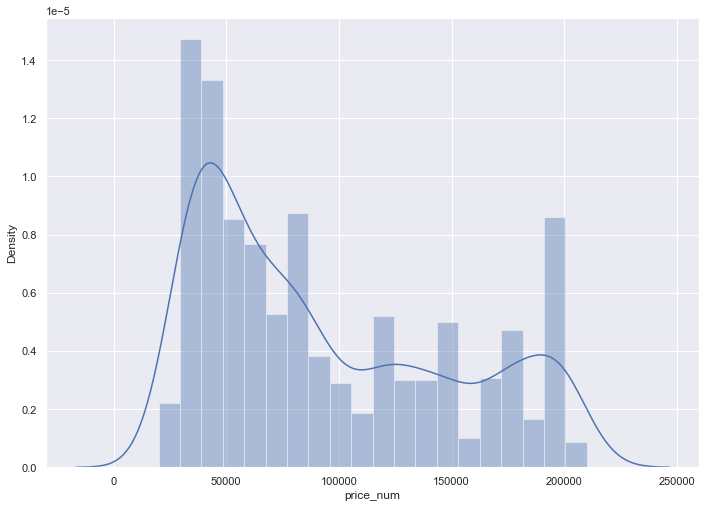

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(y, bins=20)
plt.show()

Можно было бы считать, что данные распределены нормально, есди бы мы рассматривали квартиры до 100000. Но правый хвост очень тяжелый. Можно попробовать прологарифмировать и посмотреть, не получится ли что-то лучше

/Users/olgas/study/exploratory_data/exploratory_data_analysis/venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


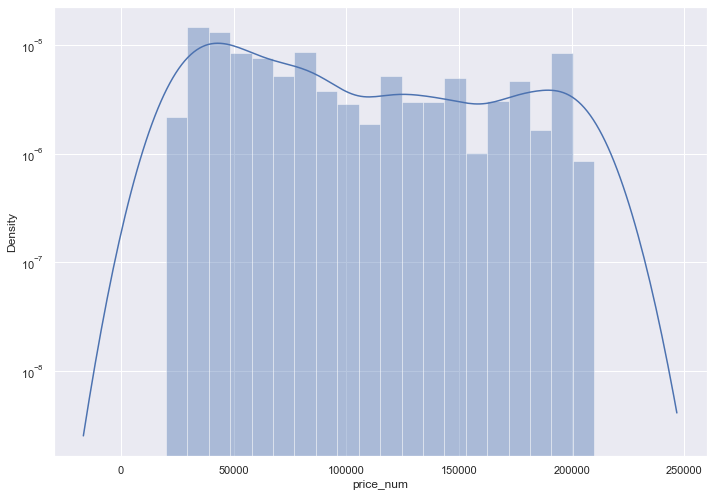

In [50]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
hist = sns.distplot(y, bins=20)
hist.set_yscale('log')
plt.show()

Логарифмическая шкала не улучшила картину. Значит, скорее всего, линейную регрессию у нас использовать не получится. 

Посмотроим матрицу корреляции:

<AxesSubplot:>

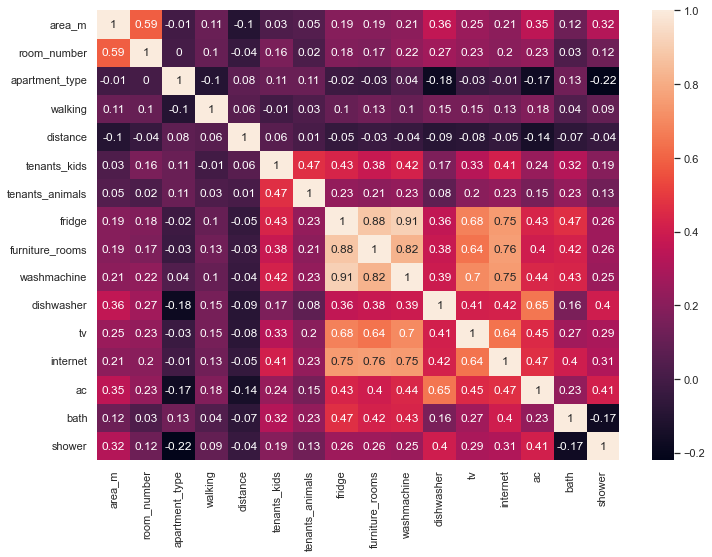

In [48]:

corr_matrix = df.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True)

В основном параметры не очень сильно коррелируют, кроме центрального квадрата. Это, в целом логично, потому что признак наличия телевизора, скорее всего связан с наличием мебели в квартире, например. 
Попробуем построить линейную регрессию: 

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [23]:
import numpy as np
lin_model = LinearRegression()
y_train_log = np.log(y_train.astype(float))
lin_model.fit(X_train, y_train_log)



LinearRegression()

Посчитаем ошибку на трейне. 

In [32]:

from sklearn.metrics import mean_squared_error, r2_score
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train_log, y_train_predict)))
r2 = r2_score(y_train_log, y_train_predict)

In [33]:
r2

0.702382451526165

И тесте:

In [36]:
y_test_predict = lin_model.predict(X_test)
y_test_log = np.log(y_test.astype(float))
rmse = (np.sqrt(mean_squared_error(y_test_log, y_test_predict)))
r2 = r2_score(y_test_log, y_test_predict)
r2

0.6628622036696411

Результат, ожидаемо, не слишком хороший. Все равно посмотрим на коэффициенты при переменных. Самый большой модуль имеет apartment_type, это может быть связано с тем, что в выборке много апартаментов с высокой ценой. Второй по модулю почему-то наличие холодильника,а дальше признак, указано ли расстрояние в минутах пешком. 


In [38]:
pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(lin_model.coef_))], axis = 1)

,0,0
0,area_m,0.011564
1,room_number,0.185416
2,apartment_type,-0.603336
3,walking,0.308960
4,distance,-0.008110
5,tenants_kids,-0.203366
6,tenants_animals,0.045133
7,fridge,0.412476
8,furniture_rooms,-0.064166
9,washmachine,-0.099184


In [ ]:
Попробуем построить RandomForest модель. Сначала нужно подобрать гиперпараметры. 

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.arange(start = 10, stop = 2000, step = 10)]
max_features = [0.5,'auto', 'sqrt','log2']
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
forest = RandomForestRegressor()
meta_forest = RandomizedSearchCV(estimator=forest, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs = -1)
meta_forest.fit(X_train, y_train)
meta_forest.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_features=0.5, min_samples_leaf=1, n_estimators=340; total time=   0.8s
[CV] END bootstrap=True, max_features=0.5, min_samples_leaf=1, n_estimators=340; total time=   0.8s
[CV] END bootstrap=True, max_features=0.5, min_samples_leaf=1, n_estimators=340; total time=   0.8s
[CV] END bootstrap=False, max_features=0.5, min_samples_leaf=2, n_estimators=1100; total time=   2.0s
[CV] END bootstrap=False, max_features=0.5, min_samples_leaf=2, n_estimators=1100; total time=   2.2s
[CV] END bootstrap=True, max_features=0.5, min_samples_leaf=4, n_estimators=1580; total time=   2.8s
[CV] END bootstrap=True, max_features=0.5, min_samples_leaf=4, n_estimators=1580; total time=   2.9s
[CV] END bootstrap=True, max_features=0.5, min_samples_leaf=4, n_estimators=1580; total time=   2.9s
[CV] END bootstrap=False, max_features=0.5, min_samples_leaf=2, n_estimators=1100; total time=   2.1s
[CV] END bootstrap=False, ma

{'n_estimators': 890,
 'min_samples_leaf': 2,
 'max_features': 0.5,
 'bootstrap': True}

In [ ]:
Итак, мы нашли наиболее подходящие параметры, теперь можно обучить модель. 

In [40]:
best_forest = RandomForestRegressor(n_estimators=890, min_samples_leaf=2, max_features=0.5, bootstrap=True)
best_forest.fit(X_train, y_train)


RandomForestRegressor(max_features=0.5, min_samples_leaf=2, n_estimators=890)

Посмотрим r2 на трейне:

In [43]:
y_train_predict = best_forest.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = r2_score(y_train, y_train_predict)
r2

0.9348422850710199

Получилось намного лучше, теперь можно посмотреть на ошибку на тесте:

In [44]:
best_forest.fit(X_test, y_test)
y_test_predict = best_forest.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
r2 = r2_score(y_test, y_test_predict)
r2

0.9242004899278867

Выглядит как хороший рещультат. Посмотрим, какие признаки являются наиболее значимыми. 

In [47]:
pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(best_forest.feature_importances_))], axis = 1)


,0,0
0,area_m,0.495973
1,room_number,0.055619
2,apartment_type,0.106968
3,walking,0.004595
4,distance,0.079252
5,tenants_kids,0.031486
6,tenants_animals,0.011795
7,fridge,0.002992
8,furniture_rooms,0.005251
9,washmachine,0.009363


В этой модели наиболее важным признаком является размер квартиры, а из "мебеольных" признаков, важной является, посудомоечная машина. Это может говорить о том, что посудомоечные машины в целом установлены в квартирах определенного типа, который может стоить дороже. 